In [1]:
# following stenum et al steps to ID gait events from vertical/frontal videos 

In [2]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
from scipy.signal import find_peaks
import os

# Gait event detection

## Frontal videos 

 Stenum et al: *Frontal Videos - We identified events of left and right gait cycles by local maxima and minima ofthe
**vertical distance** between the left and right ankle keypoints. Gait events on the left limb
were detected at positive peaks and gait events on the right limb were detected at nega-
tive peaks in trials where the participants walked away from the frontal plane camera;
and vice versa in trials where the participants walked toward the camera. In order to
unify the nomenclature ofgait events across motion capture data and sagittal and fron-
tal plane video data, we refer to the gait events ofthe frontal plane analysis as heel-
strikes.*

## to -do 
- For now, manually checking video length from visual annotation excel and using to convert frames to time. 
- Need to write code to automatically make conversion. See self care selfies code

In [3]:
# mediapipe data frame, vertical = frontal 
input_csv = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\hva_code\HomeVideoAnalysis\temp\main_branch_outputs\000_run\DS_HC_gait_vertical_left_mediapipe.csv'

# video length in seconds- by visual annotation for now 
video_length_sec = 32

df_mp = pd.read_csv(input_csv, index_col = False)

df_mp.head()

,Unnamed: 0,X,Y,Z,vis,pres,frame,label
0,0,0.564727,-0.231156,0.797350,0.996966,0.0,0,nose
1,1,0.538995,-0.261305,0.635333,0.997083,0.0,0,left_eye_inner
2,2,0.520686,-0.260609,0.634956,0.997018,0.0,0,left_eye
3,3,0.502225,-0.259820,0.634332,0.997107,0.0,0,left_eye_outer
4,4,0.588311,-0.263609,0.624654,0.996420,0.0,0,right_eye_inner


In [4]:
#rename columns 
list(df_mp.columns)
df_mp = df_mp.rename(columns = {'Unnamed: 0':'label_num'})
df_mp.head()

,label_num,X,Y,Z,vis,pres,frame,label
0,0,0.564727,-0.231156,0.797350,0.996966,0.0,0,nose
1,1,0.538995,-0.261305,0.635333,0.997083,0.0,0,left_eye_inner
2,2,0.520686,-0.260609,0.634956,0.997018,0.0,0,left_eye
3,3,0.502225,-0.259820,0.634332,0.997107,0.0,0,left_eye_outer
4,4,0.588311,-0.263609,0.624654,0.996420,0.0,0,right_eye_inner


In [5]:
# add time column 

# estimate hz from video length by eye 
total_frames = df_mp['frame'].max()
hz = total_frames/video_length_sec
print(hz)

#  tail should equal video length sec 
approx_time = df_mp['frame']/hz
approx_time.tail()

df_mp['approx_time_sec'] = approx_time

61.78125


## To do 
- Confirm Y orientation and if local mininum or maximum correspond to R or L gait events. As of 8/16/2024, code below uses positive values but plots show that this plots the stick figure "upside down". May need to use negative value of Y 
- check missing values and interpolation over missing. Stenum et al *We gap-filled keypoint trajectories using linear interpolation for gaps spanning to up 0.12 s.*
- Stenum et all supplementary figure 4 - make figure to see what filtering and moving mean combinations give most accurate results
    - moving mean script below: pd.Series(ank_y_diff).rolling(window=10, min_periods=1).mean(), change windows 

In [6]:
# create data frame with just ankles 
ank_df = df_mp.loc[(df_mp['label'] == 'left_ankle') | (df_mp['label'] == 'right_ankle')]

ank_df.head()

,label_num,X,Y,Z,vis,pres,frame,label,approx_time_sec
27,27,0.159051,0.955218,0.690832,0.926176,0.0,0,left_ankle,0.000000
28,28,0.383844,0.944809,0.550036,0.810815,0.0,0,right_ankle,0.000000
60,27,0.300395,0.957688,0.623534,0.893589,0.0,1,left_ankle,0.016186
61,28,0.439464,0.958738,0.666475,0.783434,0.0,1,right_ankle,0.016186
93,27,0.368163,0.951887,0.619579,0.833615,0.0,2,left_ankle,0.032372


In [7]:
# Plot ankle markers for all frames (make sure reasonable values)
ank_l_df = ank_df.loc[(ank_df['label'] == 'left_ankle')]
ank_r_df = ank_df.loc[(ank_df['label'] == 'right_ankle')]

In [8]:
ank_l_df.head()

,label_num,X,Y,Z,vis,pres,frame,label,approx_time_sec
27,27,0.159051,0.955218,0.690832,0.926176,0.0,0,left_ankle,0.000000
60,27,0.300395,0.957688,0.623534,0.893589,0.0,1,left_ankle,0.016186
93,27,0.368163,0.951887,0.619579,0.833615,0.0,2,left_ankle,0.032372
126,27,0.412436,0.946472,0.498464,0.805842,0.0,3,left_ankle,0.048558
159,27,0.420935,0.946748,0.460097,0.790504,0.0,4,left_ankle,0.064745


In [9]:
ank_r_df.head()

,label_num,X,Y,Z,vis,pres,frame,label,approx_time_sec
28,28,0.383844,0.944809,0.550036,0.810815,0.0,0,right_ankle,0.000000
61,28,0.439464,0.958738,0.666475,0.783434,0.0,1,right_ankle,0.016186
94,28,0.457097,0.956031,0.592309,0.729514,0.0,2,right_ankle,0.032372
127,28,0.486731,0.977997,0.631644,0.690946,0.0,3,right_ankle,0.048558
160,28,0.475279,0.986747,0.536026,0.678337,0.0,4,right_ankle,0.064745


In [10]:
# check df are same size 
print(len(ank_l_df))
print(len(ank_r_df))

1954
1954


Text(0.5, 1.0, 'Ankle Labels: DS_HC_gait_vertical_left_mediapipe.csv')

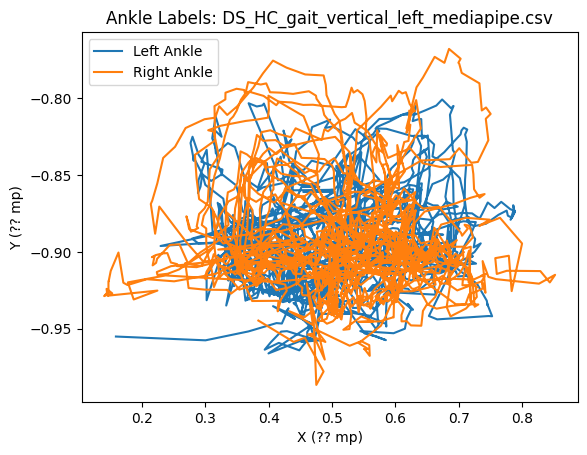

In [11]:
# plot XY position
plt.plot(ank_l_df['X'], -ank_l_df['Y'], label = 'Left Ankle')
plt.plot(ank_r_df['X'], -ank_r_df['Y'], label = 'Right Ankle')

plt.xlabel("X (?? mp)")
plt.ylabel("Y (?? mp)")
plt.legend(loc = 'best')
plt.title('Ankle Labels: ' + os.path.basename(input_csv))

Text(0.5, 1.0, 'Ankle Labels: DS_HC_gait_vertical_left_mediapipe.csv')

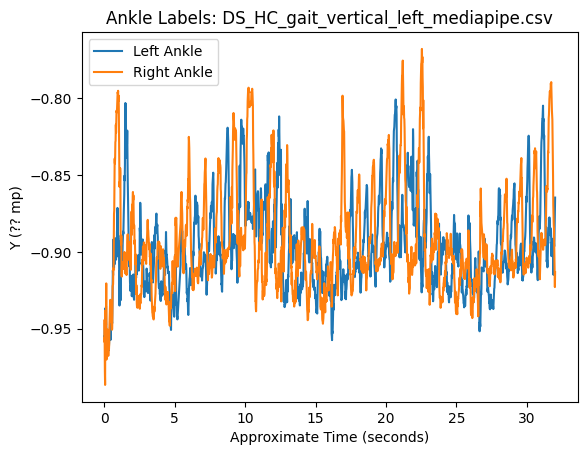

In [12]:
# plot Y vs frames 
plt.plot(ank_l_df['approx_time_sec'], -ank_l_df['Y'], label = 'Left Ankle')
plt.plot(ank_r_df['approx_time_sec'], -ank_r_df['Y'], label = 'Right Ankle')


plt.xlabel("Approximate Time (seconds)")
plt.ylabel("Y (?? mp)")
plt.legend(loc = 'best')
plt.title('Ankle Labels: ' + os.path.basename(input_csv))

In [13]:
# subtract difference between Y l and r ankle position 

# set frame as index to subtract each frmae 
ank_l_df.index = ank_l_df['frame']
ank_r_df.index = ank_r_df['frame']

In [14]:
ank_l_df.head()

,label_num,X,Y,Z,vis,pres,frame,label,approx_time_sec
frame,,,,,,,,,
0,27,0.159051,0.955218,0.690832,0.926176,0.0,0,left_ankle,0.000000
1,27,0.300395,0.957688,0.623534,0.893589,0.0,1,left_ankle,0.016186
2,27,0.368163,0.951887,0.619579,0.833615,0.0,2,left_ankle,0.032372
3,27,0.412436,0.946472,0.498464,0.805842,0.0,3,left_ankle,0.048558
4,27,0.420935,0.946748,0.460097,0.790504,0.0,4,left_ankle,0.064745


In [15]:
ank_r_df.head()

,label_num,X,Y,Z,vis,pres,frame,label,approx_time_sec
frame,,,,,,,,,
0,28,0.383844,0.944809,0.550036,0.810815,0.0,0,right_ankle,0.000000
1,28,0.439464,0.958738,0.666475,0.783434,0.0,1,right_ankle,0.016186
2,28,0.457097,0.956031,0.592309,0.729514,0.0,2,right_ankle,0.032372
3,28,0.486731,0.977997,0.631644,0.690946,0.0,3,right_ankle,0.048558
4,28,0.475279,0.986747,0.536026,0.678337,0.0,4,right_ankle,0.064745


In [16]:
# difference between Y values of left and right ankles 
# min and max of this plot are gait events 

# 1 = Y column 
ank_y_diff = ank_l_df.iloc[:,1] - ank_r_df.iloc[:,1]

# moving mean of Y difference - Stenum et al paper window = 10
ank_y_diff_movMean = pd.Series(ank_y_diff).rolling(window=10, min_periods=1).mean()

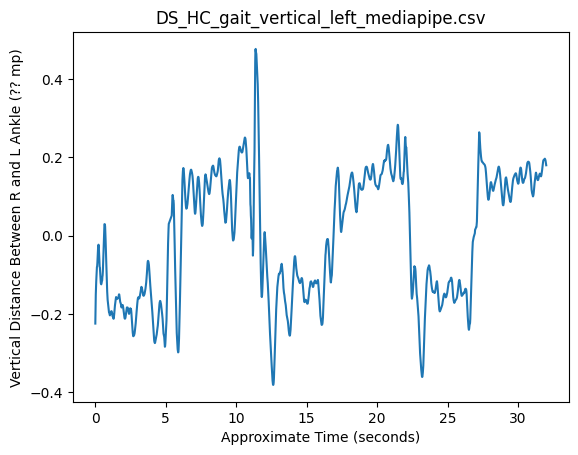

In [17]:
plt.plot(ank_l_df['approx_time_sec'], ank_y_diff_movMean)
plt.xlabel("Approximate Time (seconds)")
plt.ylabel("Vertical Distance Between R and L Ankle (?? mp)")
plt.title(os.path.basename(input_csv))
plt.show()

In [28]:
# find index of local minimum and maximum 
ank_y_diff_movMean_peaks_byFrame, _ = find_peaks(ank_y_diff_movMean)
ank_y_diff_movMean_valleys_byFrame, _ = find_peaks(-ank_y_diff_movMean)

# divide by Hz to get position of peaks in seconds, use for plots below 
ank_y_diff_movMean_peaks_bySecond = ank_y_diff_movMean_peaks_byFrame/hz
ank_y_diff_movMean_valleys_bySecond = ank_y_diff_movMean_valleys_byFrame/hz
print(len(ank_y_diff_movMean_peaks_bySecond))

# Output the local minima and maxima
print("Local maxima at positions:", ank_y_diff_movMean_peaks)
print("Number of local maxima:", len(ank_y_diff_movMean_peaks))
print("Local minima at positions:", ank_y_diff_movMean_valleys)
print("Number of local minima:", len(ank_y_diff_movMean_peaks))

76
Local maxima at positions: [ 0.22660597  0.64744562  1.14921598  1.4729388   1.61861406  1.68335862
  1.92615073  2.24987355  2.47647951  2.52503794  3.04299444  3.2696004
  3.73899848  4.59686394  5.29286798  6.05361659  6.60394537  7.10571573
  7.62367223  8.15781487  8.33586242  8.61102681  9.33940314 10.05159332
 10.21345473 10.42387456 10.73141123 10.94183106 11.18462317 11.81588265
 12.85179565 13.0298432  13.96863935 14.45422357 14.71320182 15.11785534
 15.39301973 15.60343955 16.26707132 16.2994436  16.99544765 18.01517451
 18.54931715 19.03490137 19.4881133  19.74709155 20.28123419 20.3621649
 20.57258472 21.25240263 21.4790086  21.51138088 21.78654527 21.85128983
 22.4339909  22.48254932 23.46990389 23.77744057 23.85837127 24.03641882
 24.55437532 24.92665655 25.03995953 25.6226606  25.93019727 26.05968639
 26.85280728 27.6944866  28.24481538 28.76277188 29.44258978 29.78249874
 30.33282752 30.8831563  31.15832069 31.51441578]
Number of local maxima: 76
Local minima at pos

## To - do 
Why do minimum and maximum markers shift over? Seems accurate at early frames, but later points don't align with plot local max

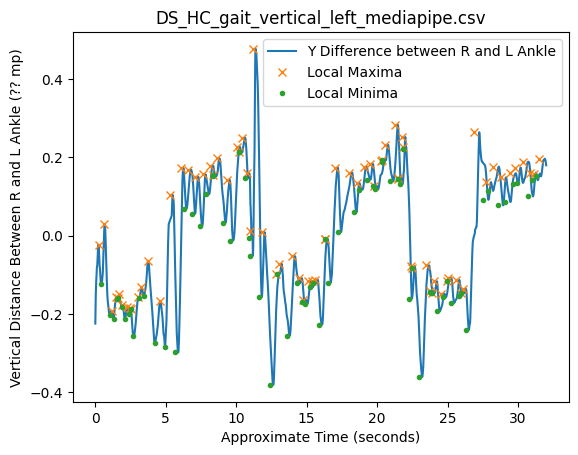

In [29]:
# plot y difference in ankles and add labels on local min and max 
plt.plot(ank_l_df['approx_time_sec'], ank_y_diff_movMean, label='Y Difference between R and L Ankle')
plt.plot(ank_y_diff_movMean_peaks_bySecond, ank_y_diff_movMean.iloc[ank_y_diff_movMean_peaks_byFrame], "x", label='Local Maxima')
plt.plot(ank_y_diff_movMean_valleys_bySecond, ank_y_diff_movMean.iloc[ank_y_diff_movMean_valleys_byFrame], ".", label='Local Minima')
plt.xlabel('Approximate Time (seconds)')
plt.ylabel("Vertical Distance Between R and L Ankle (?? mp)")
plt.legend()
plt.title(os.path.basename(input_csv))
plt.show()


## To - do 
Review PKMAS definitions and calculate the below 

In [20]:
# step time 

# Time between local max - R or L gait event (TBD)
# Time between local min - R or L  gait event (TBD) 



In [ ]:
# cadence 

In [ ]:
# total double support % (Mean) 

In [ ]:
# Total Double Support % - Ratio - L/R

In [ ]:
# Single Support % - Ratio - L/R

In [ ]:
# Single Support % - Mean 